# LOAD DATA

In [2]:
import pandas as pd
import ast

In [3]:
dataframe = pd.read_csv('data/xiami/dataframe.csv')

In [ ]:
dataframe['song_ids_order'] = dataframe['song_ids_order'].apply(ast.literal_eval)

In [ ]:
# min 2 itens para input
# 1 item para recomendacao
# 1 item para avaliacao

dataframe = dataframe[dataframe['length'] > 3]

In [ ]:
dataframe['last_item'] = dataframe['song_ids_order'].apply(lambda x: x.pop() if len(x) > 0 else None)

In [ ]:
all_songs = set([item for sublist in dataframe['song_ids_order'] for item in sublist])

In [ ]:
dataframe = dataframe[dataframe['last_item'].isin(all_songs)]

In [ ]:
sequences = dataframe['song_ids_order']

# MODEL

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    '''Callback para registrar a perda após cada época.'''
    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_previous_step
        self.loss_previous_step = loss
        self.losses.append(loss_now)
        print(f'Perda após época {self.epoch}: {loss_now}')
        self.epoch += 1

epoch_logger = EpochLogger()

class EarlyStoppingCallback(CallbackAny2Vec):
    '''Callback para early stopping baseado em uma melhoria percentual na perda.'''
    def __init__(self, epoch_logger, patience=3, min_percent_improvement=0.01):
        self.epoch_logger = epoch_logger
        self.patience = patience  # número de épocas sem melhoria
        self.min_percent_improvement = min_percent_improvement  # percentual mínimo de melhoria
        self.best_loss = float('inf')  # inicializar com um valor alto
        self.counter = 0  # contar épocas sem melhoria

    def on_epoch_end(self, model):
        loss_now = self.epoch_logger.losses[-1]  # Obter a última perda registrada pelo EpochLogger
        
        # Checar se houve uma melhoria percentual significativa
        if self.best_loss == float('inf'):
            improvement = float('inf')
        else:
            improvement = (self.best_loss - loss_now) / self.best_loss

        print(f'Melhoria percentual: {improvement * 100:.2f}%')

        if improvement > self.min_percent_improvement:
            self.best_loss = loss_now
            self.counter = 0  # Resetar o contador de épocas sem melhoria
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            
            # Parar se o número de épocas sem melhoria exceder a paciência
            if self.counter >= self.patience:
                print(f'Early stopping ativado na época {self.epoch_logger.epoch}')
                model.running_training = False  # Isso interrompe o treinamento

early_stopping = EarlyStoppingCallback(epoch_logger=epoch_logger, patience=3, min_percent_improvement=0.01)

In [10]:
from gensim.models import Word2Vec

model = Word2Vec(
    sequences,
    vector_size=128,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    negative=10,
    epochs=25,
    sample=0.001,
    alpha=0.03,
    min_alpha=0.0007,
    compute_loss=True,
    callbacks=[epoch_logger, early_stopping]
)

Perda após época 0: 12143144.0
Melhoria percentual: inf%
Perda após época 1: 6610376.0
Melhoria percentual: 45.56%
Perda após época 2: 5431748.0
Melhoria percentual: 17.83%
Perda após época 3: 4856114.0
Melhoria percentual: 10.60%
Perda após época 4: 4365920.0
Melhoria percentual: 10.09%
Perda após época 5: 2710458.0
Melhoria percentual: 37.92%
Perda após época 6: 2392868.0
Melhoria percentual: 11.72%
Perda após época 7: 2127452.0
Melhoria percentual: 11.09%
Perda após época 8: 2081976.0
Melhoria percentual: 2.14%
Perda após época 9: 1936384.0
Melhoria percentual: 6.99%
Perda após época 10: 1832816.0
Melhoria percentual: 5.35%
Perda após época 11: 1787104.0
Melhoria percentual: 2.49%
Perda após época 12: 1742392.0
Melhoria percentual: 2.50%
Perda após época 13: 1698408.0
Melhoria percentual: 2.52%
Perda após época 14: 1715368.0
Melhoria percentual: -1.00%
Early stopping counter: 1/3
Perda após época 15: 1673120.0
Melhoria percentual: 1.49%
Perda após época 16: 1609588.0
Melhoria percen

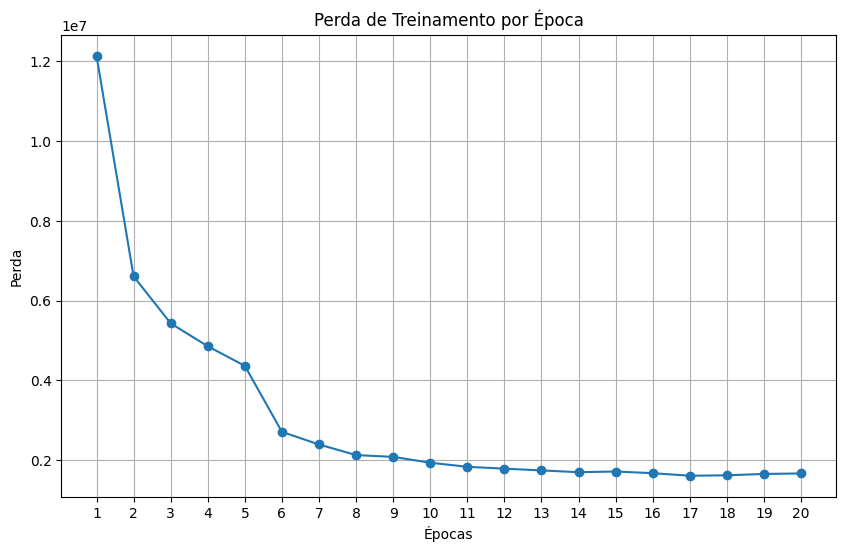

In [12]:
import matplotlib.pyplot as plt

losses = epoch_logger.losses

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda de Treinamento por Época')
plt.xticks(range(1, len(losses) + 1))
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
import numpy as np

def get_average_embedding(song_ids, model):
    embeddings = []
    for song_id in song_ids:
        song_id_str = str(song_id)  # Converte para string se necessário
        if song_id_str in model.wv:
            embeddings.append(model.wv[song_id_str])
        else:
            # Opcional: Trate IDs desconhecidos conforme necessário
            pass
    if embeddings:
        # Calcula a média dos embeddings
        avg_embedding = np.mean(embeddings, axis=0)
        return avg_embedding
    else:
        # Retorna um vetor de zeros se nenhum embedding foi encontrado
        return np.zeros(model.vector_size)

# Aplicar a função ao dataframe
dataframe['average_embedding'] = dataframe['song_ids_order'].apply(lambda x: get_average_embedding(x, model))

In [31]:
import numpy as np
import faiss

# Extrair os IDs das músicas e seus embeddings
song_ids = list(model.wv.index_to_key)
embeddings = np.array([model.wv[song_id] for song_id in song_ids]).astype('float32')

In [32]:
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

In [33]:
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Usando Inner Product para similaridade cosseno
index.add(embeddings)

In [35]:
average_embeddings = np.stack(dataframe['average_embedding'].values).astype('float32')
average_embeddings = average_embeddings / np.linalg.norm(average_embeddings, axis=1, keepdims=True)

In [36]:
k = 10  # Número de vizinhos mais próximos
distances, indices = index.search(average_embeddings, k)

In [37]:
similar_song_ids = [[song_ids[idx] for idx in neighbors] for neighbors in indices]
dataframe['similar_song_ids'] = similar_song_ids

In [39]:
def check_last_item_in_similar(row):
    last_item = str(row['last_item'])  # Garantir que 'last_item' seja uma string
    similar_ids = row['similar_song_ids']
    return last_item in similar_ids

# Aplicar a função ao dataframe
dataframe['is_last_item_in_similar'] = dataframe.apply(check_last_item_in_similar, axis=1)

In [42]:
dataframe.groupby('is_last_item_in_similar').size()

is_last_item_in_similar
False    133243
True      40180
dtype: int64